# Evaluate Model 
---
Confusion Matrix
A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. 

Precision
precision = (TP) / (TP+FP)
TP is the number of true positives, and FP is the number of false positives. 
A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). This would not be very useful since the classifier would ignore all but one positive instance. 
 
Recall
recall = (TP) / (TP+FN)
TP is the number of true positives, and FP is the number of false negatives. 
Recall is defined as ratio of the number of retrieved and relevant documents(the number of items retrieved that are relevant to the user and match his needs) to the number of possible relevant documents(number of relevant documents in the database)[Source](https://www.geeksforgeeks.org/precision-and-recall-in-information-retrieval/#:~:text=Recall%20is%20defined%20as%20ratio,relevant%20documents%20in%20the%20database)

It is often convenient to combine precision and recall into a single metric called the F1 score, in particular, if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall. The F1 score favors classifiers that have similar precision and recall.[Source](https://www.geeksforgeeks.org/confusion-matrix-machine-learning)

In [1]:
# Import library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from tqdm import tqdm

# Open file
import os
import PIL
import cv2
from os import listdir
from random import shuffle

# Model CNN (Deep learning network)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,\
GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report,f1_score

In [2]:
def create_label(word_label):
    ''' 
        Input : subdirectories path have nane file with class label 
        Return : number of classes label of each class 
    '''
    if word_label == "cocci":
        return 0
    elif word_label == "healthy":
        return 1
    elif word_label == "ncd":
        return 2
    elif word_label == "salmo":
        return 3

In [3]:
def created_dataset(DIR):
    '''
        Input : directories file have image file to want label   
        Return : dataframe of arrary image (RGB-3D shape) follow by img_height and img_width and label of each classes image 
    '''
    created_dataset = []
    for labels_c in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, labels_c)
        for file in listdir(path):
            img_data = cv2.imread(path+ "/" + file) 
            img_data = cv2.resize(img_data, (img_height , img_width))
            img_data = cv2.cvtColor(img_data, cv2.COLOR_RGB2BGR)
            created_dataset.append([np.array(img_data), create_label(labels_c)])
    shuffle(created_dataset)
    return pd.DataFrame(created_dataset, columns=["picture","labels"])

In [4]:
def load_model(model_path):
    '''
        Input : subdirectories of model 
        Return : model of keras api with not complie 
    '''
    model = tf.keras.models.load_model(model_path, compile = False)
    return model

In [6]:
# Create function plot graph
def plot_graph(history_model, finetune=False, initial_epochs=0):
    ''' 
        Input : Model_values of keras.callbacks.History
        Return : Graph of Loss funtion and Mean squared error between training dataset and testing dataset
    '''
    # Subplots
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history_model['loss'], label='Training Loss');
    plt.plot(history_model['val_loss'], label='Testing Loss');
    if finetune==True:
        plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(fontsize=12, loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss');
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history_model['accuracy'], label='Training Accuracy')
    plt.plot(history_model['val_accuracy'], label='Validation Accuracy')
    if finetune==True:
        plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(fontsize=12, loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy');

In [5]:
def get_metric(model, X,  y_actual, name_model=None):
    '''
        Input : model = model of keras api 
                X = array of image follow by reshape and rescale fit for model input 
                y_actual = label of each image(X)
                name_model = str name of model want to show 
        Return : ConfusionMatrixDisplay, accuracy_score and size of model 
    '''
    prods_softmax = model.predict(X)
    y_preds = np.array([np.where(v == v.max())[0][0] for v in prods_softmax])
    print(f"Model : {name_model}")
    print("-"*50)
    labels = ['cocci', 'healthy', 'ncd', 'salmo']
    cm = confusion_matrix(y_actual, y_preds)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(cmap=plt.cm.Blues);
    print(classification_report(y_actual, y_preds, target_names=labels))
    print(f"Accuracy score: {round(accuracy_score(y_actual, y_preds),2)}")
    print(f"F1 score average: {round(f1_score(y_actual, y_preds, average = 'macro'),2)}")

In [49]:
def get_values_model(X , y_actual, history_model, model, name_model="", model_path=None):
 
    ''' Show the overall metric model
        Parameter : X = array of image follow by reshape and rescale fit for model input
                    y_actual : label of each image(X)
                    history_model : model_values of keras.callbacks.History
                    model : model of keras api 
                    name_model : str name of model want to show
                    model_path : subdirectories of model 
        Return : Add value of model to set of 
                model_name, loss, val_loss, accuracy, val_accuracy, F1_score, size_mb, number_params, input_size   
    '''
    
    # Predict model 
    prods_softmax = model.predict(X)
    y_preds = np.array([np.where(v == v.max())[0][0] for v in prods_softmax])
    
    # Add values
    model_name.append(name_model)
    loss.append(round(history_model.iloc[-1]["loss"],2))
    val_loss.append(round(history_model.iloc[-1]["val_loss"],2))
    accuracy.append(round(history_model.iloc[-1]["accuracy"],2))
    val_accuracy.append(round(history_model.iloc[-1]["val_accuracy"],2))
    F1_score.append(round(f1_score(y_actual, y_preds, average = 'macro'),2))
    size_mb.append(round(os.stat(model_path).st_size/1_048_576 , 2))
    number_params.append(f'{model.count_params():,}')
    input_size.append(model.input_shape)

### 01 Open dataset 
---

In [7]:
# Open path file of dataset 
dataset_path_new = "dataset_train_valid_test/"

valid_dir = os.path.join(dataset_path_new, "valid")
test_dir = os.path.join(dataset_path_new, "test")

### Preprocessing image dataset 
---

In [8]:
# Create dataframe of validation and testing dataset 
# for model CNN and mobileNetV2
# Using input image size 128x128
img_height=128
img_width=128
df_valid = created_dataset(DIR=valid_dir)
df_test = created_dataset(DIR=test_dir)

100%|██████████| 4/4 [00:59<00:00, 14.82s/it]


In [9]:
# Recheck
df_valid.head()

,picture,labels
0,"[[[96, 102, 98], [98, 106, 93], [97, 110, 93],...",0
1,"[[[191, 178, 184], [196, 182, 189], [185, 168,...",1
2,"[[[138, 128, 127], [155, 148, 148], [166, 161,...",1
3,"[[[152, 160, 148], [155, 156, 148], [160, 161,...",1
4,"[[[205, 205, 205], [208, 208, 208], [213, 213,...",1


In [10]:
# Recheck
df_test.head()

,picture,labels
0,"[[[200, 172, 135], [195, 166, 132], [198, 172,...",0
1,"[[[145, 149, 147], [78, 84, 85], [149, 159, 16...",2
2,"[[[142, 142, 142], [143, 143, 143], [147, 143,...",1
3,"[[[145, 152, 166], [154, 165, 169], [170, 180,...",1
4,"[[[145, 120, 124], [145, 126, 128], [151, 131,...",1


In [11]:
# Define X and y for
X_valid = np.array([i for i in df_valid["picture"]]).reshape(-1, img_height,img_width, 3)/ 255.0
y_valid = df_valid["labels"]
X_test = np.array([i for i in df_test["picture"]]).reshape(-1, img_height,img_width, 3)/ 255.0
y_test = df_test["labels"]

In [12]:
# Check shape before prediction with model
X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((816, 128, 128, 3), (816,), (805, 128, 128, 3), (805,))

In [13]:
# Check class in y_valid
pd.Series(y_valid).value_counts(normalize=True).mul(100).sort_index(ascending=True)

0    30.269608
1    33.823529
2     6.617647
3    29.289216
Name: labels, dtype: float64

In [14]:
# Check class in y_test
pd.Series(y_test).value_counts(normalize=True).mul(100).sort_index(ascending=True)

0    28.819876
1    27.950311
2     7.204969
3    36.024845
Name: labels, dtype: float64

In [15]:
# Define labels dictionary of each class
labels_dict = {'cocci':0, 'healthy':1, 'ncd':2, 'salmo':3}

---

### 02. Baseline Model CNN

In [16]:
# path of model 
cnn_path = "../model/cnn/cnn_model.h5"

# load model 
cnn_model = load_model(model_path=cnn_path)

In [17]:
# check model summary
# 2,102,564 parameters
# Get file size in bytes for a given model
print(f"Size of model(MB): {(os.stat(cnn_path).st_size/1_048_576)}") # convert Bytes to MB

cnn_model.summary()

Size of model(MB): 24.107223510742188
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)    

26/26 [==============================] - 5s 11ms/step
Model : Cnn Model
--------------------------------------------------
              precision    recall  f1-score   support

       cocci       0.93      0.93      0.93       247
     healthy       0.88      0.89      0.89       276
         ncd       0.64      0.87      0.73        54
       salmo       0.93      0.83      0.88       239

    accuracy                           0.88       816
   macro avg       0.84      0.88      0.86       816
weighted avg       0.89      0.88      0.89       816

Accuracy score: 0.88
F1 score average: 0.86


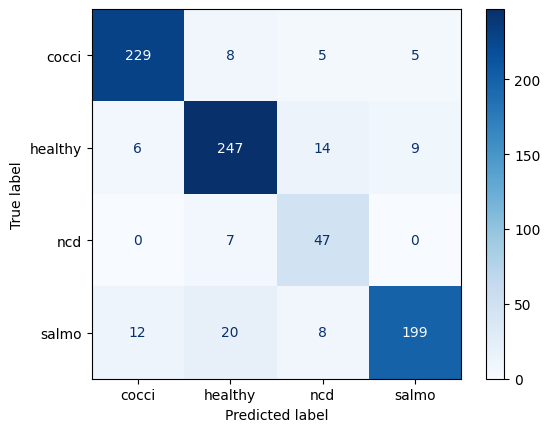

In [19]:
# See confusion_matrix of model 
get_metric(model=cnn_model,
          X=X_valid,
          name_model="Cnn Model",
          y_actual=y_valid)

        loss  accuracy  val_loss  val_accuracy
20  0.134372  0.958440  0.485084      0.877451
21  0.150795  0.949205  0.574125      0.849265
22  0.131211  0.953438  0.452003      0.877451
23  0.117395  0.959338  0.572854      0.859069
24  0.139426  0.948692  0.447357      0.882353


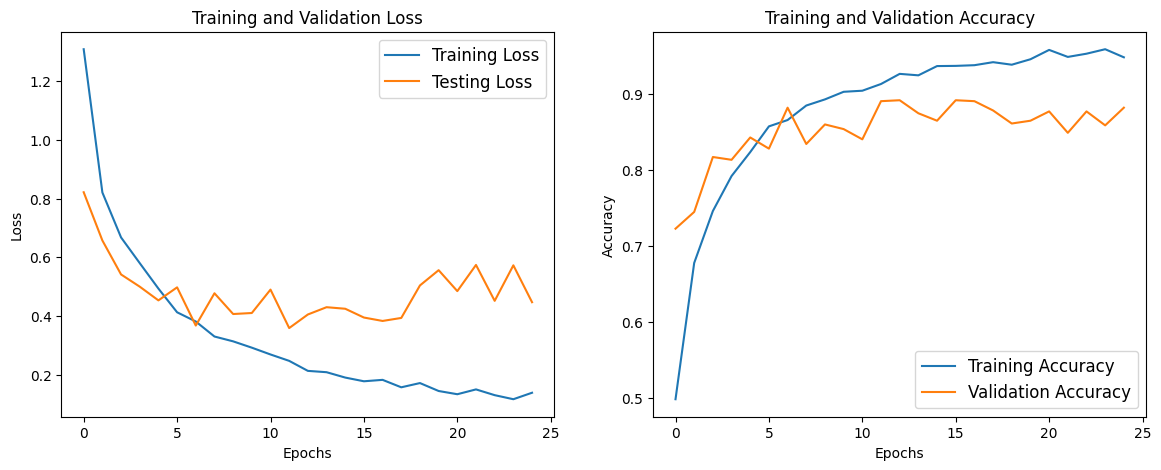

In [20]:
# See history of model  training
histort_cnn_model = pd.read_csv("../model/cnn/history_cnn16.csv", index_col="Unnamed: 0")
plot_graph(histort_cnn_model)
print(histort_cnn_model.tail())

In [21]:
# CNN model 
# Slightly overfit between training and vaildation
# Accuracy score : 0.95 and 0.88 %
# Loss function : 0.14 and 0.45 %
# F1 score average: 0.86 %
# Size of model 24.10 MB 
# 2M parameters

---

### 03. Transfer Learning and Fine Tuning MobileNetV2 Model 

In [22]:
# path of model 
mobnv2_tf_path = "../model/mobilenetV2/mobilenetv2.h5"
mobnv2_ft_path = "../model/mobilenetV2/mobilenetv2_ft.h5"

# load model 
mobnv2_tf_model = load_model(model_path=mobnv2_tf_path)
mobnv2_ft_model = load_model(model_path=mobnv2_ft_path)

In [23]:
# check model summary
# Total params: 2,263,108 parameters (equal params between transfer learning and fine tuning )
# Get file size in bytes for a given model
print(f"Size of MobileNetV2 transfer learning model(MB): {(os.stat(mobnv2_tf_path).st_size/1_048_576)}") # convert Bytes to MB
print(f"Size of MobileNetV2 fine tuning model(MB): {(os.stat(mobnv2_ft_path).st_size/1_048_576)}")

Size of MobileNetV2 transfer learning model(MB): 9.131431579589844
Size of MobileNetV2 fine tuning model(MB): 23.464256286621094


In [24]:
# check model summary
# Trainable params: 5,124
mobnv2_tf_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 16, 16, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 16, 16, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 16, 16, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 16, 16, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 8, 8, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 8, 8, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 8, 8, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 8, 8, 96)    384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 8, 8, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 8, 8, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 8, 8, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 4, 4, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 4, 4, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 4, 4, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 4, 4, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [25]:
# check model summary
# Trainable params: 1,866,564
mobnv2_ft_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_5[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 16, 16, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 16, 16, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 16, 16, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 16, 16, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 8, 8, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 8, 8, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 8, 8, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 8, 8, 96)    384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 8, 8, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 8, 8, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 8, 8, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 4, 4, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 4, 4, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 4, 4, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 4, 4, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

26/26 [==============================] - 3s 48ms/step
Model : MobileNetV2 Transfer Learning Model
--------------------------------------------------
              precision    recall  f1-score   support

       cocci       0.96      0.94      0.95       247
     healthy       0.94      0.88      0.91       276
         ncd       0.67      0.93      0.78        54
       salmo       0.90      0.91      0.90       239

    accuracy                           0.91       816
   macro avg       0.87      0.91      0.88       816
weighted avg       0.92      0.91      0.91       816

Accuracy score: 0.91
F1 score average: 0.88


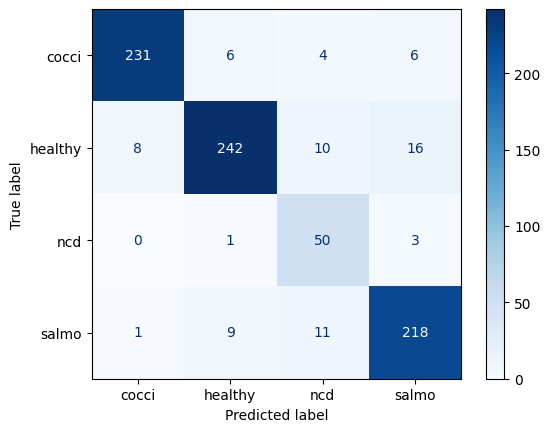

In [26]:
# See confusion_matrix of model 
get_metric(model=mobnv2_tf_model,
          X=X_valid,
          name_model="MobileNetV2 Transfer Learning Model",
          y_actual=y_valid)

26/26 [==============================] - 2s 42ms/step
Model : MobileNetV2 Model
--------------------------------------------------
              precision    recall  f1-score   support

       cocci       0.99      0.80      0.89       247
     healthy       0.82      0.88      0.85       276
         ncd       0.60      0.93      0.73        54
       salmo       0.89      0.88      0.88       239

    accuracy                           0.86       816
   macro avg       0.82      0.87      0.84       816
weighted avg       0.88      0.86      0.86       816

Accuracy score: 0.86
F1 score average: 0.84


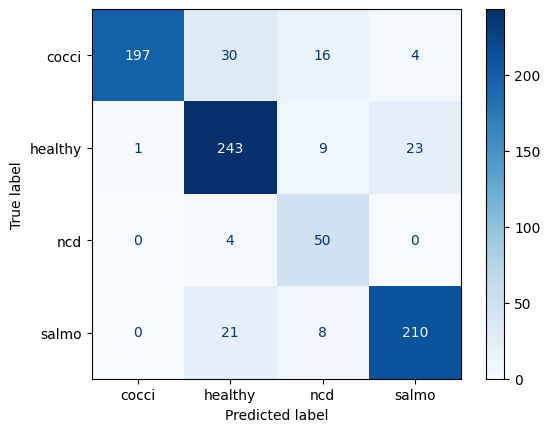

In [27]:
# See confusion_matrix of model 
get_metric(model=mobnv2_ft_model,
          X=X_valid,
          name_model="MobileNetV2 Model",
          y_actual=y_valid)

In [28]:
# See history of model training both transfer learing or fine tuning
histort_mobnv2_tf_model = pd.read_csv("../model/mobilenetV2/history_mobilenetv2.csv", index_col="Unnamed: 0")
histort_mobnv2_ft_model = pd.read_csv("../model/mobilenetV2/history_mobilenetv2_ft.csv", index_col="Unnamed: 0")
histort_mobnv2_model = pd.concat([histort_mobnv2_tf_model, histort_mobnv2_ft_model], ignore_index=True)
histort_mobnv2_model.tail()

,loss,accuracy,val_loss,val_accuracy
30,0.056197,0.981786,7.854601,0.611520
31,0.045372,0.985505,1.473425,0.839461
32,0.040165,0.986403,4.588133,0.736520
33,0.052517,0.981786,2.396793,0.840686
34,0.036762,0.989097,1.426730,0.857843


In [29]:
# See only history of model training transfer learing
histort_mobnv2_tf_model.tail()

,loss,accuracy,val_loss,val_accuracy
20,0.075367,0.979733,0.294830,0.908088
21,0.070812,0.982812,0.297860,0.908088
22,0.069724,0.983453,0.306500,0.906863
23,0.067251,0.983453,0.307697,0.908088
24,0.062783,0.984864,0.318748,0.900735


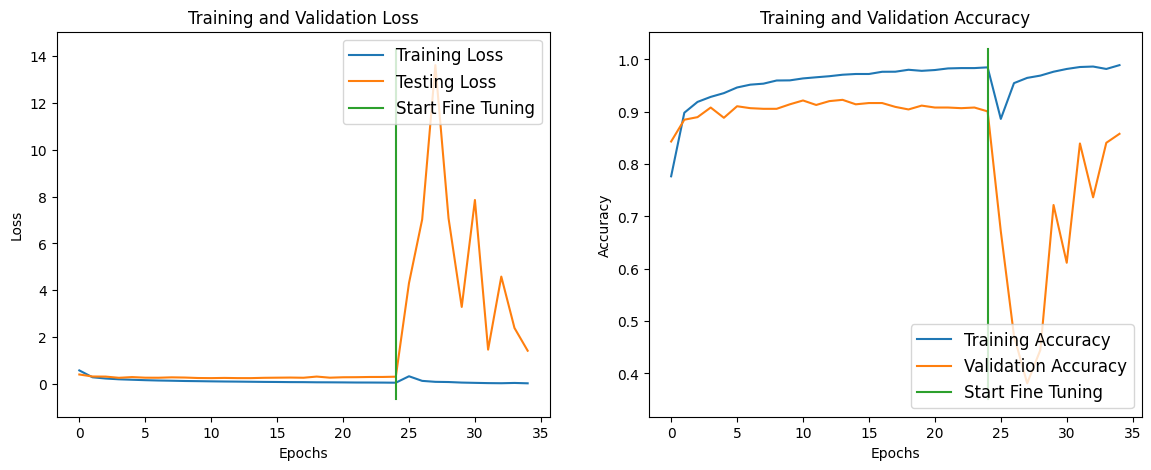

In [30]:
# Show graph
plot_graph(histort_mobnv2_model,finetune=True, initial_epochs=25)

In [31]:
# MobileNetV2 model 
##  Transfer learning
### Slightly overfit between training and vaildation
### Accuracy score : 0.98 and 0.90 %
### Loss function : 0.06 and 0.32 %
### F1 score average: 0.88 %
### Size of model 9.14 MB 
### 2.2M parameters

##  Fine tuning
### Slightly overfit between training and vaildation
### Accuracy score : 0.99 and 0.86 %
### Loss function : 0.04 and 1.43 %
### F1 score average: 0.84 % 
### Size of model 23.46 MB 
### 2.2M parameters

# Fine tuning lower performance the Transfer learning might be architecture of model be trained by 224x224x3 
# when we use 128x128x3 is not comfortable for model 

---

### 03. Transfer Learning and Fine Tuning VGG16 Model 

In [32]:
# Create dataframe of validation and testing dataset 
# for model VGG16 
# Using input image size 224x224
img_height= 224
img_width= 224
df_valid_224 = created_dataset(DIR=valid_dir)
df_test_224 = created_dataset(DIR=test_dir)

100%|██████████| 4/4 [00:54<00:00, 13.75s/it]


In [33]:
# Define X and y and reshape
X_valid_224 = np.array([i for i in df_valid_224["picture"]]).reshape(-1, img_height,img_width, 3)/ 255.0
y_valid_224 = df_valid_224["labels"]
X_test_224 = np.array([i for i in df_test_224["picture"]]).reshape(-1, img_height,img_width, 3)/ 255.0
y_test_224 = df_test_224["labels"]

In [34]:
# Check shape before prediction with model
X_valid_224.shape, y_valid_224.shape, X_test_224.shape, y_test_224.shape

((816, 224, 224, 3), (816,), (805, 224, 224, 3), (805,))

In [35]:
# path of model 
vgg16_tf_path = "../model/vgg16/vgg_16.h5"
vgg16_ft_path = "../model/vgg16/vgg_16_ft.h5"

# load model 
vgg16_tf_model = load_model(model_path=vgg16_tf_path)
vgg16_ft_model = load_model(model_path=vgg16_ft_path)

In [36]:
# check model summary
# Total params: 14,716,740 parameters (equal params between transfer learning and fine tuning )
# Get file size in bytes for a given model
print(f"Size of VGG16 transfer learning model(MB): {(os.stat(vgg16_tf_path).st_size/1_048_576)}") # convert Bytes to MB
print(f"Size of VGG16 fine tuning model(MB): {(os.stat(vgg16_ft_path).st_size/1_048_576)}")

Size of VGG16 transfer learning model(MB): 56.23210144042969
Size of VGG16 fine tuning model(MB): 110.25601196289062


In [37]:
# check model summary
vgg16_tf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [38]:
# check model summary
vgg16_ft_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

26/26 [==============================] - 24s 521ms/step
Model : VGG16 Transfer Learning Model
--------------------------------------------------
              precision    recall  f1-score   support

       cocci       0.86      0.79      0.83       247
     healthy       0.89      0.81      0.85       276
         ncd       0.35      0.74      0.47        54
       salmo       0.86      0.80      0.83       239

    accuracy                           0.80       816
   macro avg       0.74      0.79      0.74       816
weighted avg       0.84      0.80      0.81       816

Accuracy score: 0.8
F1 score average: 0.74


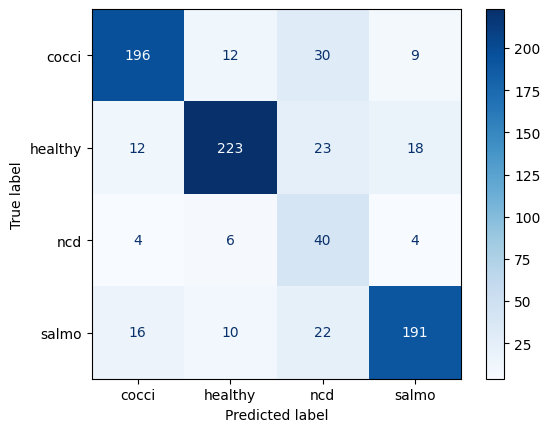

In [40]:
# See confusion_matrix of model 
get_metric(model=vgg16_tf_model,
          X=X_valid_224,
          name_model="VGG16 Transfer Learning Model",
          y_actual=y_valid_224)

26/26 [==============================] - 7s 283ms/step
Model : VGG16 Fine Tuning Model
--------------------------------------------------
              precision    recall  f1-score   support

       cocci       0.96      0.96      0.96       247
     healthy       0.91      0.93      0.92       276
         ncd       0.70      0.91      0.79        54
       salmo       0.96      0.87      0.92       239

    accuracy                           0.92       816
   macro avg       0.88      0.92      0.90       816
weighted avg       0.93      0.92      0.92       816

Accuracy score: 0.92
F1 score average: 0.9


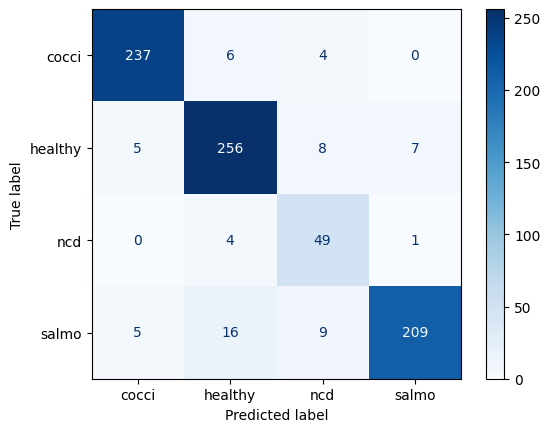

In [41]:
# See confusion_matrix of model 
get_metric(model=vgg16_ft_model,
          X=X_valid_224,
          name_model="VGG16 Fine Tuning Model",
          y_actual=y_valid_224)

In [42]:
# See history of model training both transfer learing or fine tuning
histort_vgg16_tf_model = pd.read_csv("../model/vgg16/history_vgg16.csv", index_col="Unnamed: 0")
histort_vgg16_ft_model = pd.read_csv("../model/vgg16/history_vgg16_ft.csv", index_col="Unnamed: 0")
histort_vgg16_model = pd.concat([histort_vgg16_tf_model, histort_vgg16_ft_model], ignore_index=True)
histort_vgg16_model.tail()

,loss,accuracy,val_loss,val_accuracy
30,0.126509,0.959210,0.250897,0.922794
31,0.100163,0.966008,0.347682,0.911765
32,0.079281,0.972422,0.258790,0.932598
33,0.072892,0.975372,0.279060,0.924020
34,0.067488,0.973576,0.288808,0.920343


In [43]:
# See only history of model training transfer learing
histort_vgg16_tf_model.tail()

,loss,accuracy,val_loss,val_accuracy
20,0.517807,0.815675,0.538256,0.806373
21,0.511832,0.817342,0.536848,0.803922
22,0.507525,0.819908,0.522360,0.810049
23,0.503598,0.821703,0.542037,0.791667
24,0.498907,0.822473,0.544401,0.796569


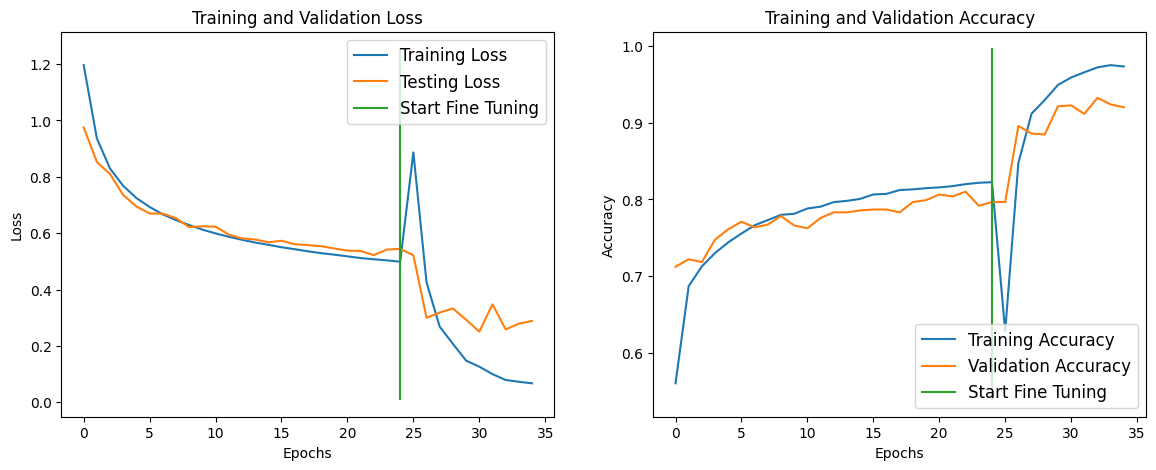

In [44]:
# plot graph
plot_graph(histort_vgg16_model,finetune=True, initial_epochs=25)

In [45]:
# VGG16 model 
##  Transfer learning
### Not overfit between training and vaildation
### Accuracy score transfer learning : 0.98 and 0.90 %
### Loss function : 0.06 and 0.32 %
### F1 score average: 0.87 %
### Size of model 9.14 MB 
### 2.2M parameters

##   Fine tuning
### Slightly overfit between training and vaildation
### Accuracy score transfer learning : 0.99 and 0.93 %
### Loss function : 0.03 and 0.70 %
### F1 score average: 
### Size of model  MB 
### 2.2M parameters

---

### 04. Evaluate model 

In [46]:
# list 
model_name, loss, val_loss, accuracy, val_accuracy, F1_score, size_mb, number_params, input_size =  [],[],[],[],[],[],[],[],[]

In [47]:
# Check shape before prediction with model of CNN and MobileNetV2
X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((816, 128, 128, 3), (816,), (805, 128, 128, 3), (805,))

In [48]:
# Check shape before prediction with model of VGG16
X_valid_224.shape, y_valid_224.shape, X_test_224.shape, y_test_224.shape

((816, 224, 224, 3), (816,), (805, 224, 224, 3), (805,))

In [50]:
# Cnn model
get_values_model(X_valid, 
                 y_valid, 
                 history_model=histort_cnn_model,
                 model=cnn_model,
                 name_model="CNN_Baseline",
                 model_path=cnn_path)

26/26 [==============================] - 0s 7ms/step


In [51]:
# MobileNetV2 Transfer learning
get_values_model(X_valid, 
                 y_valid, 
                 history_model=histort_mobnv2_tf_model,
                 model=mobnv2_tf_model,
                 name_model="MobileNetV2_tf",
                 model_path=mobnv2_tf_path)

# MobileNetV2 Fine_tuning
get_values_model(X_valid, 
                 y_valid, 
                 history_model=histort_mobnv2_ft_model,
                 model=mobnv2_ft_model,
                 name_model="MobileNetV2_ft",
                 model_path=mobnv2_ft_path)

26/26 [==============================] - 1s 34ms/step


In [52]:
# VGG16 Transfer learning
get_values_model(X=X_valid_224, 
                 y_actual=y_valid_224, 
                 history_model=histort_vgg16_tf_model,
                 model=vgg16_tf_model,
                 name_model="VGG16_tf",
                 model_path=vgg16_tf_path)

# VGG16 Fine_tuning
get_values_model(X=X_valid_224, 
                 y_actual=y_valid_224, 
                 history_model=histort_vgg16_ft_model,
                 model=vgg16_ft_model,
                 name_model="VGG16_ft",
                 model_path=vgg16_ft_path)

26/26 [==============================] - 9s 357ms/step


In [53]:
# Create Dataframe
result_model = pd.DataFrame(data = [model_name, loss, val_loss, accuracy, val_accuracy, F1_score, size_mb, number_params, input_size],\
               index = ['model_name','loss','val_loss','accuracy','val_accuracy','F1_score','size_mb','number_params', "input_size"])

In [55]:
# Show results
result_model

,0,1,2,3,4
model_name,CNN_Baseline,MobileNetV2_tf,MobileNetV2_ft,VGG16_tf,VGG16_ft
loss,0.14,0.06,0.04,0.5,0.07
val_loss,0.45,0.32,1.43,0.54,0.29
accuracy,0.95,0.98,0.99,0.82,0.97
val_accuracy,0.88,0.9,0.86,0.8,0.92
F1_score,0.86,0.88,0.84,0.74,0.9
size_mb,24.11,9.13,23.46,56.23,110.26
number_params,"2,102,564","2,263,108","2,263,108","14,716,740","14,716,740"
input_size,"(None, 128, 128, 3)","(None, 128, 128, 3)","(None, 128, 128, 3)","(None, 224, 224, 3)","(None, 224, 224, 3)"


The performances of all models were practicable and the accuracy score (>80%) in the validation dataset. The selected model MobileNetV2 Transfer Learning was the small size with the highest accuracy at 0.90. Moreover, the size of the input could be smaller when compared to VGG16 models with low parameter levels In addition, the F1 score was equal to 0.84 which can exhibit high performance.

---

### 05. Test selected model in testing dataset before deploy to app 

In [56]:
# MobileNetV2 Transfer learning in testing dataset
get_values_model(X=X_test, 
                 y_actual=y_test, 
                 history_model=histort_mobnv2_tf_model,
                 model=mobnv2_tf_model,
                 name_model="MobileNetV2_tf_bestmodel",
                 model_path=mobnv2_tf_path)

26/26 [==============================] - 1s 50ms/step


In [57]:
# Create Dataframe
selected_model = pd.DataFrame(data = [model_name, loss, val_loss, accuracy, val_accuracy, F1_score, size_mb, number_params, input_size],\
               index = ['model_name','loss','val_loss','accuracy','val_accuracy','F1_score','size_mb','number_params', "input_size"])

In [61]:
# Show metric of selected model MobileNetV2_tf_bestmodel
selected_model[[5]]

,5
model_name,MobileNetV2_tf_bestmodel
loss,0.06
val_loss,0.32
accuracy,0.98
val_accuracy,0.9
F1_score,0.9
size_mb,9.13
number_params,"2,263,108"
input_size,"(None, 128, 128, 3)"


26/26 [==============================] - 1s 36ms/step
Model : MobileNetV2 Model
--------------------------------------------------
              precision    recall  f1-score   support

       cocci       0.95      0.96      0.95       232
     healthy       0.92      0.91      0.92       225
         ncd       0.75      0.86      0.80        58
       salmo       0.95      0.92      0.94       290

    accuracy                           0.93       805
   macro avg       0.89      0.91      0.90       805
weighted avg       0.93      0.93      0.93       805

Accuracy score: 0.93
F1 score average: 0.9


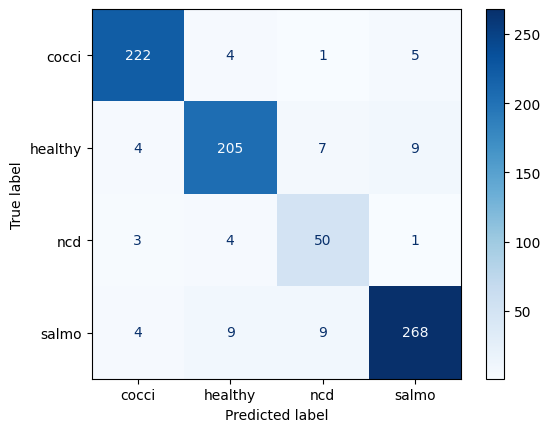

In [63]:
# See confusion_matrix of selected model 
get_metric(model=mobnv2_tf_model,
          X=X_test,
          name_model="MobileNetV2 Model",
          y_actual=y_test)

Last, we tested the performance of the model on the testing dataset was the accuracy score 0.93 and the F1 score was equal to 0.90.

---

## 06. Additional paths

1/1 [==============================] - 0s 30ms/step


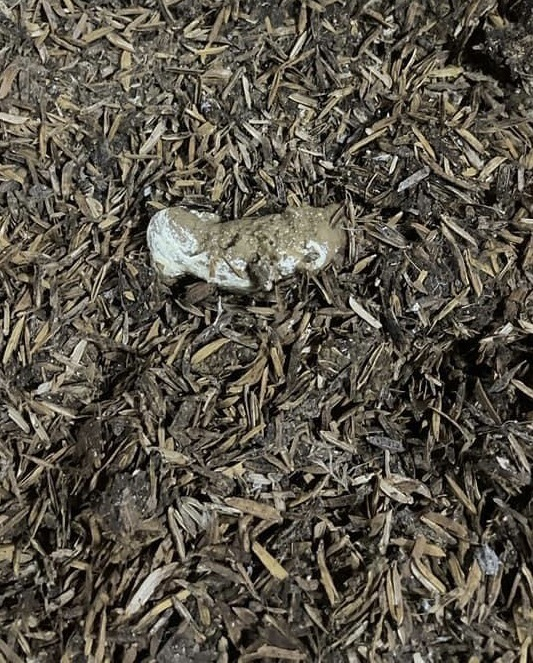

This image most likely belongs to healthy with a 47.27 percent confidence.


In [67]:
# Test actual picture form Thailand farmer 
model = mobnv2_tf_model

# load image
path = "../picture/healthy_thai_1.jpg"
img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Predict
predictions = model.predict(img_array*1/255.)
score = tf.nn.softmax(predictions[0])
display(Image(filename=path))
print("This image most likely belongs to {} with a {:.2f} percent confidence."
.format([j for j in labels_dict if labels_dict[j] == np.argmax(score)][0], 100 * np.max(score)))

1/1 [==============================] - 0s 37ms/step


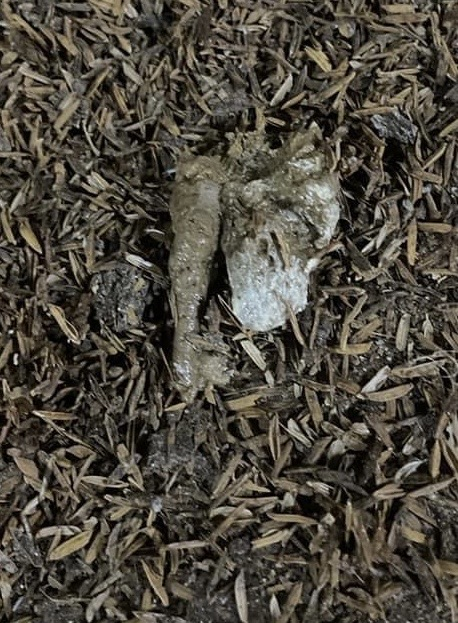

This image most likely belongs to healthy with a 46.48 percent confidence.


In [68]:
# Test actual picture form Thailand farmer 
model = mobnv2_tf_model

# load image
path = "../picture/healthy_thai_2.jpg"
img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Predict
predictions = model.predict(img_array*1/255.)
score = tf.nn.softmax(predictions[0])
display(Image(filename=path))
print("This image most likely belongs to {} with a {:.2f} percent confidence."
.format([j for j in labels_dict if labels_dict[j] == np.argmax(score)][0], 100 * np.max(score)))

In [69]:
## the model good performance to predict other picture in other country

---